<a href="https://colab.research.google.com/github/dapopov-st/MiniLlamaSQL/blob/main/Fine_tune_CodeLlama_7b_Instruct_step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune CodeLlama-7b-Instruct on b-mc2-sql-create-context.ipynb

Built starting from  [Colab NB](https://colab.research.google.com/drive/1PEQyJO1-f6j0S_XJ8DV50NkpzasXkrzd?usp=sharing).

This notebook runs on a A100 GPU on Colab. (Last update: 24 Aug 2023)


##NOTES (remove after training)
- ThingsSolver/nsql-eng
-  b-mc2-sql-create-context which is a combo of WikiSQL and Spider and was used to produce good results (?) here: https://www.anyscale.com/blog/fine-tuning-llama-2-a-comprehensive-case-study-for-tailoring-models-to-unique-applications#sql-generation-with-llama-2-fine-tuned-models
- Train with LoRA and MERGE as in https://medium.com/@bnjmn_marie/lora-load-and-merge-your-adapters-with-care-3204119f0426: essentially LoRA adaptor weights will merge with model weights for new model weights. For quality, LoRA all the layers!!!
- b-mc2/sql-create-context dataset from Hugging Face, which is a combination of the WikiSQL and Spider datasets.
- If want more data, can train on https://huggingface.co/datasets/NumbersStation/NSText2SQL (almost 300K, combined multiple datasets, could subselect but need to sort through)
- Randomly selected eval set was too easy.
- The overall generation quality appears to have gone up (former eval needed)
- Starting from last checkpoint and finetuning on Spider only

### TODOS:
- Careful with merging: train for a little, set up merging and eval before train for longer
- Consider 8bit bnb for greater accuracy (perpahs, but second prio)

# Llama 2 Script

## TODOS:
Try additional datasets (merge)
- https://huggingface.co/datasets/b-mc2/sql-create-context
- Mistral or Zephyr 7b
- Evaluate on SQLEval https://defog.ai/blog/open-sourcing-sqleval/ (question/answer/context format) just like knowrohit07/know_sql. Possibly include Clinton/Text-to-sql-v1 (much larger dataset, include/rename columns I need)
- If stick with Llama (or better yet, CodeLlama Phind/Phind-CodeLlama-34B-v2 or TheBloke/CodeLlama-7B-GGUF, TheBloke/CodeLlama-13B-Instruct-GGUF; or better yet https://huggingface.co/codellama/CodeLlama-34b-Instruct-hf CodeLlama instruct, which was also finetuned on SQL), can distill knowledge to TinyLlama TinyLlama/TinyLlama-1.1B-intermediate-step-715k-1.5T.  If use this approach, likely need to spin up a cluster on GCP.
- Consder fine tuning on CoSQL (harder)

Additional:
- https://www.datacamp.com/tutorial/mistral-7b-tutorial is quite good for Mistral finetuning/general finetuning advice
- Bing Chat Experimental: According to the web search results I found for you, both Code-Llama Instruct 7b and SQLCoder 7B are state-of-the-art large language models for generating SQL queries from natural language123. However, based on the performance benchmarks reported by their developers, SQLCoder 7B seems to have a slight edge over Code-Llama Instruct 7b in terms of execution accuracy12. SQLCoder 7B achieved 71% correct SQL queries on a novel dataset not seen in training, while Code-Llama Instruct 7b achieved 70%2. SQLCoder 7B also outperformed Code-Llama Instruct 7b on most query categories, such as date, group by, order by, ratio, and join2. However, Code-Llama Instruct 7b has the advantage of being faster and more suitable for low latency tasks, as it can be served on a single GPU3. SQLCoder 7B requires a more powerful hardware setup, such as an A100 40GB GPU or an RTX 40902. Therefore, the answer to your question may depend on your specific use case and preferences.
- If the above is accurate, Code-LLama would probably be best for distillation to TinyLLama-1.1B.

- Bing: According to the web search results, CodeLlama-7b-Instruct was not fine-tuned on b-mc2/sql-create-context. However, there are some other models that were fine-tuned on this dataset, such as qblocks/llama2_SQL_Answers_finetuned1 and TheBloke/CodeLlama-7B-Instruct-GPTQ2. These models are available on Hugging Face3 and can be used for generating SQL queries from natural language questions.

## Installs and Config

- To set up the tokenizer for CodeLlama-7b-Instruct model fine tuning, you need to install the transformers library from the main development branch, as the CodeLlamaTokenizer class is not available in the latest release yet1. You can do this by running the following command in your terminal:


In [1]:
#!pip install git+https://github.com/huggingface/transformers.git@main

In [1]:
!pip install -q transformers==4.35.2 accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7 datasets==2.10.1 wandb==0.16.0 adapters==0.1.0
#transformers==4.31.0

In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    LlamaForCausalLM,
    LlamaTokenizer,
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer


In [3]:
from IPython.core.display import display, HTML

# Set the code page width to a larger value
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
from huggingface_hub import login
login()

In [5]:
import wandb # do from scipt later
wandb.login()
%env WANDB_PROJECT=sql-fine-tuning

wandb: Currently logged in as: dpopovvelasco. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=sql-fine-tuning


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

output_dir = '/content/drive/MyDrive/SQL/sql_output_dir'
logging_dir = '/content/drive/MyDrive/SQL/sql_logging_dir'
%cd /content/drive/MyDrive/SQL
!ls .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SQL
sql_logging_dir  sql_output_dir  sql.yml  wandb


In [8]:
import sys,gc,traceback
import torch
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''



def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
clean_mem()

## Original HF Script

In [ ]:

# coding=utf-8
# Copyright 2023 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
from dataclasses import dataclass, field
from typing import Optional

import torch
from datasets import load_dataset
from peft import LoraConfig
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
)

from trl import SFTTrainer

# This example fine-tunes Llama v2 model on Guanace dataset
# using QLoRA. At the end of the script we perform merging the weights
# Use it by correctly passing --model_name argument when running the
# script.
#
# Versions used:
# accelerate == 0.21.0
# peft == 0.4.0
# bitsandbytes == 0.40.2
# transformers == 4.31.0
# trl == 0.4.7

# For models that have `config.pretraining_tp > 1` install:
# pip install git+https://github.com/huggingface/transformers.git

@dataclass
class ScriptArguments:
    """
    These arguments vary depending on how many GPUs you have, what their capacity and features are, and what size model you want to train.
    """

    local_rank: Optional[int] = field(default=-1, metadata={"help": "Used for multi-gpu"})

    per_device_train_batch_size: Optional[int] = field(default=4)
    per_device_eval_batch_size: Optional[int] = field(default=1)
    gradient_accumulation_steps: Optional[int] = field(default=4)
    learning_rate: Optional[float] = field(default=2e-4)
    max_grad_norm: Optional[float] = field(default=0.3)
    weight_decay: Optional[int] = field(default=0.001)
    lora_alpha: Optional[int] = field(default=16)
    lora_dropout: Optional[float] = field(default=0.1)
    lora_r: Optional[int] = field(default=64)
    max_seq_length: Optional[int] = field(default=512)
    model_name: Optional[str] = field(
        default="meta-llama/Llama-2-7b-hf",
        metadata={
            "help": "The model that you want to train from the Hugging Face hub. E.g. gpt2, gpt2-xl, bert, etc."
        }
    )
    dataset_name: Optional[str] = field(
        default="timdettmers/openassistant-guanaco",
        metadata={"help": "The preference dataset to use."},
    )
    use_4bit: Optional[bool] = field(
        default=True,
        metadata={"help": "Activate 4bit precision base model loading"},
    )
    use_nested_quant: Optional[bool] = field(
        default=False,
        metadata={"help": "Activate nested quantization for 4bit base models"},
    )
    bnb_4bit_compute_dtype: Optional[str] = field(
        default="float16",
        metadata={"help": "Compute dtype for 4bit base models"},
    )
    bnb_4bit_quant_type: Optional[str] = field(
        default="nf4",
        metadata={"help": "Quantization type fp4 or nf4"},
    )
    num_train_epochs: Optional[int] = field(
        default=1,
        metadata={"help": "The number of training epochs for the reward model."},
    )
    fp16: Optional[bool] = field(
        default=False,
        metadata={"help": "Enables fp16 training."},
    )
    bf16: Optional[bool] = field(
        default=False,
        metadata={"help": "Enables bf16 training."},
    )
    packing: Optional[bool] = field(
        default=False,
        metadata={"help": "Use packing dataset creating."},
    )
    gradient_checkpointing: Optional[bool] = field(
        default=True,
        metadata={"help": "Enables gradient checkpointing."},
    )
    optim: Optional[str] = field(
        default="paged_adamw_32bit",
        metadata={"help": "The optimizer to use."},
    )
    lr_scheduler_type: str = field(
        default="constant",
        metadata={"help": "Learning rate schedule. Constant a bit better than cosine, and has advantage for analysis"},
    )
    max_steps: int = field(default=10000, metadata={"help": "How many optimizer update steps to take"})
    warmup_ratio: float = field(default=0.03, metadata={"help": "Fraction of steps to do a warmup for"})
    group_by_length: bool = field(
        default=True,
        metadata={
            "help": "Group sequences into batches with same length. Saves memory and speeds up training considerably."
        },
    )
    save_steps: int = field(default=10, metadata={"help": "Save checkpoint every X updates steps."})
    logging_steps: int = field(default=10, metadata={"help": "Log every X updates steps."})
    merge_and_push: Optional[bool] = field(
        default=False,
        metadata={"help": "Merge and push weights after training"},
    )
    output_dir: str = field(
        default="./results",
        metadata={"help": "The output directory where the model predictions and checkpoints will be written."},
    )


parser = HfArgumentParser(ScriptArguments)
script_args = parser.parse_args_into_dataclasses()[0]


def create_and_prepare_model(args):
    compute_dtype = getattr(torch, args.bnb_4bit_compute_dtype)

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=args.use_4bit,
        bnb_4bit_quant_type=args.bnb_4bit_quant_type,
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=args.use_nested_quant,
    )

    if compute_dtype == torch.float16 and args.use_4bit:
        major, _ = torch.cuda.get_device_capability()
        if major >= 8:
            print("=" * 80)
            print("Your GPU supports bfloat16, you can accelerate training with the argument --bf16")
            print("=" * 80)

    # Load the entire model on the GPU 0
    # switch to `device_map = "auto"` for multi-GPU
    device_map = {"": 0}

    model = AutoModelForCausalLM.from_pretrained(
        args.model_name,
        quantization_config=bnb_config,
        device_map=device_map,
        use_auth_token=True
    )

    # check: https://github.com/huggingface/transformers/pull/24906
    model.config.pretraining_tp = 1

    peft_config = LoraConfig(
        lora_alpha=script_args.lora_alpha,
        lora_dropout=script_args.lora_dropout,
        r=script_args.lora_r,
        bias="none",
        task_type="CAUSAL_LM",
    )

    tokenizer = AutoTokenizer.from_pretrained(script_args.model_name, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token

    return model, peft_config, tokenizer


training_arguments = TrainingArguments(
    output_dir=script_args.output_dir,
    per_device_train_batch_size=script_args.per_device_train_batch_size,
    gradient_accumulation_steps=script_args.gradient_accumulation_steps,
    optim=script_args.optim,
    save_steps=script_args.save_steps,
    logging_steps=script_args.logging_steps,
    learning_rate=script_args.learning_rate,
    fp16=script_args.fp16,
    bf16=script_args.bf16,
    max_grad_norm=script_args.max_grad_norm,
    max_steps=script_args.max_steps,
    warmup_ratio=script_args.warmup_ratio,
    group_by_length=script_args.group_by_length,
    lr_scheduler_type=script_args.lr_scheduler_type,
)

model, peft_config, tokenizer = create_and_prepare_model(script_args)
model.config.use_cache = False
dataset = load_dataset(script_args.dataset_name, split="train")

# Fix weird overflow issue with fp16 training
tokenizer.padding_side = "right"

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=script_args.max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=script_args.packing,
)

trainer.train()

if script_args.merge_and_push:
    output_dir = os.path.join(script_args.output_dir, "final_checkpoints")
    trainer.model.save_pretrained(output_dir)

    # Free memory for merging weights
    del model
    torch.cuda.empty_cache()

    from peft import AutoPeftModelForCausalLM

    model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)
    model = model.merge_and_unload()

    output_merged_dir = os.path.join(script_args.output_dir, "final_merged_checkpoint")
    model.save_pretrained(output_merged_dir, safe_serialization=True)

## My script below

In [ ]:
# import os
# from dataclasses import dataclass, field
# from typing import Optional
# from datasets.arrow_dataset import Dataset
# import torch
# from datasets import load_dataset
# from peft import LoraConfig
# from peft import AutoPeftModelForCausalLM
# from transformers import (
#     AutoModelForCausalLM,
#     AutoTokenizer,
#     BitsAndBytesConfig,
#     HfArgumentParser,
#     AutoTokenizer,
#     TrainingArguments,
#     #Dataset,
#     DataCollatorForLanguageModeling
# )

# from trl import SFTTrainer


# # Used for multi-GPU setup; -1 default means single GPU
# local_rank=-1
# #Will likely need to adjust (to 1?) when see memory consumption
# per_device_train_batch_size=4
# per_device_eval_batch_size=4
# gradient_accumulation_steps =4 # if change batch size to 1, increase this to 16
# learning_rate=2e-5
# # Maximum norm for gradient cliping
# max_grad_norm=0.3
# weight_decay=0.01
# lora_alpha=16
# lora_dropout=0.1
# lora_r=32
# # Should be OK, but may need to adjust in conjunction with per_device_batch_size and gradient_accumulation_steps
# max_seq_length=512

# model_name="codellama/CodeLlama-7b-Instruct-hf" #Adjusted

# dataset_name="b-mc2/sql-create-context"
# #activate 4-bit precision base model loading
# use_4bit=True

# use_nested_quant=False #can use different levels of precision at different levels of the model, can help balance accuracy and computational efficiency

# bnb_4bit_compute_dtype="float16" #computations performed in 16 bit; can lower accuracy, experiment
# # Q: Why use nested quantization nf4 with use_nested_quant=False?
# bnb_4bit_quant_type="nf4"
# # OK, maybe set this to 1 or two. Adjust in conjunction with max_steps
# num_train_epochs=100
# # MosaicML: use bf16 over fp16 for training. bf16 tends to be more numerically stable. Can use on A100, I think, but not on T4.
# fp16=False
# bf16=True
# # I think I should set packing = True, not sure why HF set to false for Llama2 finetune
# packing=False
# # Store some but not all intermediate outputs from the forward pass to reduce training
# gradient_checkpointing=True
# #TODO: May need to adjust to 8bit (16bit?) for T4
# optim="paged_adamw_32bit"
# #May consider cosine since not much learning happens at the start (perhaps OK if it's an extended warmup step in essense)
# lr_scheduler_type="constant"
# #Adjust to, say 100; specifies the total number of training steps to perform. A training step is one iteration over a batch of inputs, followed by optimization of the model parameters based on the calculated loss.  Can be useful for more control when training over a large ds; consider doing 1 epoch w/
# #num_train_epochs=1 once working
# max_steps=1000000
# # Fraction of steps to use for warmup
# warmup_ratio=0.03
# # I guess since not using packing, can group by length to save memoryand speed up training
# group_by_length=True
# #Save checkpoint every X steps
# save_steps=50
# #Log every X updates steps.
# logging_steps=50
# # Merge and push weights after training
# merge_and_push=False
# #The output directory where the model predictions and checkpoints will be written.
# output_dir=output_dir

## Load and Prepare the Data

In [23]:
import datasets
from copy import deepcopy
dataset = datasets.load_dataset('b-mc2/sql-create-context',split='train')

orig_dataset = deepcopy(dataset)
dataset

Dataset({
    features: ['question', 'context', 'answer'],
    num_rows: 78577
})

In [24]:
orig_len=len(dataset)

In [25]:
orig_dataset

Dataset({
    features: ['question', 'context', 'answer'],
    num_rows: 78577
})

In [26]:
import matplotlib.pyplot as plt
MAX_LEN = 512
def get_reg_and_long_seq_lengths(dataset):
  seq_lens = []
  seq_long = set()
  for idx, example in enumerate(dataset):
    seq_lens.append(len(example['question']+example['context']+example['answer']))
    if seq_lens[idx] > MAX_LEN:
      seq_long.add(idx)
  return seq_lens, seq_long

def plot_seq_lens(seq_lens):
  plt.hist(seq_lens, bins = 100)
  plt.xlabel("Sequence Length")
  plt.ylabel("Count")
  plt.title("Sequence Lenghts Distribution")
  plt.show()

seq_lens, seq_long = get_reg_and_long_seq_lengths(dataset)


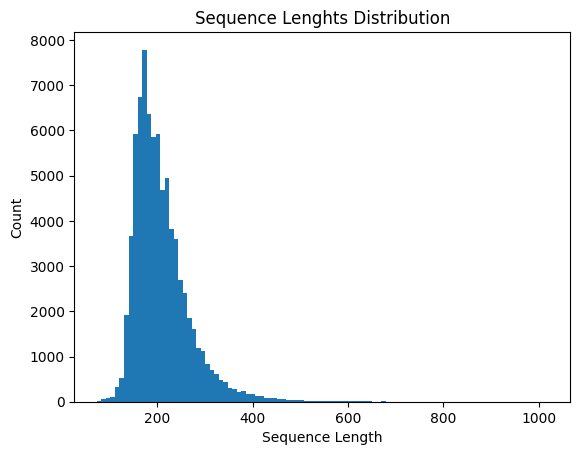

In [27]:
plot_seq_lens(seq_lens)

In [28]:
print(f"Percentage of sequences over {MAX_LEN}: {len(seq_long)*100/len(seq_lens)}%")
print(f"Min and max length sequences: {min(seq_lens)}, {max(seq_long)}")

Percentage of sequences over 512: 0.2914338801430444%
Min and max length sequences: 73, 76859


- The number of validation steps is determined by the size of the validation dataset and the batch size for evaluation. Picking a very small val datasize now for speed of evaluation, ideally pick a larger one when more compute resources are available.

In [29]:
dataset

Dataset({
    features: ['question', 'context', 'answer'],
    num_rows: 78577
})

- SFTTrainer expect a single 'text' column

In [30]:
VAL_SIZE = .0004
def format_prompt(sample):
    """Given a sample dictionary with keys "title" and "abstract" format into a prompt.

    Args:
      sample: A sample dictionary from a Hugging Face dataset.

    Returns:
      sample: sample dictionary with "text" key for the formatted prompt.
    """
    sample['text']=f"<s>[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> {sample['question']} {sample['context']} [/INST] {sample['answer']}</s>"
    return sample
def preprocess_dataset(dataset):
          return (dataset
          #.select(i for i in range(len(dataset)) if i not in seq_long)
          .shuffle(1337)
          .train_test_split(test_size=VAL_SIZE)
          .map(format_prompt, remove_columns=['question', 'context', 'answer']))
dataset = preprocess_dataset(orig_dataset)

Map:   0%|          | 0/78545 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [31]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 78545
    })
    test: Dataset({
        features: ['text'],
        num_rows: 32
    })
})

In [36]:
# for i, example in enumerate(dataset['test']):
#   print(f"Example {i}")
#   print(example['text'])


## Configure Model, Data, Tokenizer, Trainer

### LoRA of QLoRA (configured in LoraConfig)
-  lora_alpha=16, # rank of the adaptor matrices, tunable hyperparam; may consider 4 or 8 to reduce number of parameters and speed up computation
-  task_type="CAUSAL_LM" for generative modeling
- Choose which layers to quantize; QLoRA paper had full quantization for intermediate layers while LoRA quantized QV.  Model printout below shows where they are coming from.


#### Q of QLoRA (quantization configured in BitsAndBytesConfig
- Enable Quantization with BitsAndBytesConfig
- Model's weights are frozen and stored in nf4 format, when need to perform compuation, confert to bf16 for stability

In [20]:
# import transformers
# MODEL_ID = "codellama/CodeLlama-7b-Instruct-hf"
# model_id = MODEL_ID
# #model_id = "TheBloke/Mistral-7B-Instruct-v0.1-GGUF"

# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type='nf4',
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# model_config = transformers.AutoConfig.from_pretrained(model_id)


# model = transformers.AutoModelForCausalLM.from_pretrained(
#     model_id,
#     trust_remote_code=True,
#     config=model_config,
#     quantization_config=bnb_config, #using bnb_config
#     device_map='auto'
# )
# model.gradient_checkpointing_enable()


config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Fine-tune the model using a small number of parameters of an adopter layer, making the entire process faster and more memory-efficient.

In [21]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32016, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

- Use the following peft cofig to get more adaptor parameters
```python
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM", #for generative modeling
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj","up_proj", "down_proj",'lm_head']
)
```


In [27]:
clean_mem()

In [9]:
MODEL_ID='codellama/CodeLlama-7b-Instruct-hf'
def create_and_prepare_model(args):
    compute_dtype = getattr(torch, args.bnb_4bit_compute_dtype)

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=args.use_4bit,
        bnb_4bit_quant_type=args.bnb_4bit_quant_type,
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=args.use_nested_quant,
    )

    if compute_dtype == torch.float16 and args.use_4bit:
        major, _ = torch.cuda.get_device_capability()
        if major >= 8:
            print("=" * 80)
            print("Your GPU supports bfloat16, you can accelerate training with the argument --bf16")
            print("=" * 80)

    # Load the entire model on the GPU 0
    # switch to `device_map = "auto"` for multi-GPU
    device_map = {"": 0}

    model = AutoModelForCausalLM.from_pretrained(
        args.model_name,
        quantization_config=bnb_config,
        device_map=device_map,
        use_auth_token=True,
        # revision="refs/pr/35"
    )

    # check: https://github.com/huggingface/transformers/pull/24906
    model.config.pretraining_tp = 1
    # model.config.
    #### LLAMA STUFF
    #model.config.window = 256
    model.gradient_checkpointing_enable()

    peft_config = LoraConfig(
        lora_alpha=script_args.lora_alpha,
        lora_dropout=script_args.lora_dropout,
        # target_modules=["query_key_value"],
        r=script_args.lora_r,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    )

    tokenizer = AutoTokenizer.from_pretrained(script_args.model_name, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token

    return model, peft_config, tokenizer
# Will be easier to convert nb cells to script later with namedtuple (same syntax)
from collections import namedtuple
script_args_ = {
    "local_rank": -1,
    "per_device_train_batch_size": 8,#4
    "per_device_eval_batch_size": 8,#4
    "gradient_accumulation_steps": 2,#4
    "learning_rate": 2e-5,
    "max_grad_norm": 0.3,
    "weight_decay": 0.01,
    "lora_alpha": 16,
    "lora_dropout": 0.1,
    "lora_r": 32,
    "max_seq_length": 1024, #512 # Trying to use more of GPU, will collate
    "model_name": "codellama/CodeLlama-7b-Instruct-hf",
    "dataset_name": "b-mc2/sql-create-context",
    "use_4bit": True,
    "use_nested_quant": False,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_type": "nf4",
    "num_train_epochs": 2, #100,
    "fp16": True,# Switch around
    "bf16": False, # if have A100
    "packing": False,#True,
    "gradient_checkpointing": True,
    "optim": "paged_adamw_32bit",
    "lr_scheduler_type": "constant",
    "max_steps": 1000, #1000000
    "warmup_ratio": 0.03,
    "group_by_length": True,
    "save_steps": 100,
    "logging_steps": 10,
    "merge_and_push": False,
    "output_dir": output_dir
}
ScriptArgs = namedtuple('ScriptArgs',script_args_.keys())
script_args = ScriptArgs(*script_args_.values())
training_arguments = TrainingArguments(
    output_dir=script_args.output_dir,
    per_device_train_batch_size=script_args.per_device_train_batch_size,
    gradient_accumulation_steps=script_args.gradient_accumulation_steps,
    optim=script_args.optim,
    save_steps=script_args.save_steps,
    logging_steps=script_args.logging_steps,
    learning_rate=script_args.learning_rate,
    fp16=script_args.fp16,
    bf16=script_args.bf16,
    evaluation_strategy="steps",
    max_grad_norm=script_args.max_grad_norm,
    max_steps=script_args.max_steps,
    warmup_ratio=script_args.warmup_ratio,
    group_by_length=script_args.group_by_length,
    lr_scheduler_type=script_args.lr_scheduler_type,
    report_to='wandb',
)
# Step 1: Get model, peft_config_tokenizer here
model, peft_config, tokenizer = create_and_prepare_model(script_args)
model.config.use_cache = False

#**************************************************************************#
# Step 2: Load and preprocess dataset here
# dataset = load_dataset(script_args.dataset_name, split="train")
VAL_SIZE = .0004
def format_prompt(sample):
    """Given a sample dictionary with keys "title" and "abstract" format into a prompt.

    Args:
      sample: A sample dictionary from a Hugging Face dataset.

    Returns:
      sample: sample dictionary with "text" key for the formatted prompt.
    """
    sample['text']=f"<s>[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> {sample['question']} {sample['context']} [/INST] {sample['answer']}</s>"
    return sample
def preprocess_dataset(dataset):
          return (dataset
          #.select(i for i in range(len(dataset)) if i not in seq_long)
          .shuffle(1337)
          .train_test_split(test_size=VAL_SIZE)
          .map(format_prompt, remove_columns=['question', 'context', 'answer']))
from copy import deepcopy
dataset = load_dataset('b-mc2/sql-create-context',split='train')

orig_dataset = deepcopy(dataset)
dataset = preprocess_dataset(orig_dataset)
# dataset = dataset['train'].train_test_split(train_size=0.8, seed=DS_SEED)
#**************************************************************************#

# Step 3: Launch training with SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=script_args.max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=script_args.packing,
)

trainer.train()


config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/b-mc2___json/b-mc2--sql-create-context-21a3552632daf3cf/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


Map:   0%|          | 0/78545 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/78545 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

You are using 8-bit optimizers with a version of `bitsandbytes` < 0.41.1. It is recommended to update your version as a major bug has been fixed in 8-bit optimizers.


wandb: Currently logged in as: dpopovvelasco. Use `wandb login --relogin` to force relogin


You're using a CodeLlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
10,3.148300,3.421934
20,3.217100,3.141676
30,3.036200,2.759101
40,2.646700,2.232763
50,2.065200,1.658101
60,1.509600,1.440819
70,1.385100,1.276691
80,1.212500,1.162358
90,1.049500,1.082592
100,0.937300,1.052384


TrainOutput(global_step=1000, training_loss=0.8242044401168823, metrics={'train_runtime': 7292.5878, 'train_samples_per_second': 2.194, 'train_steps_per_second': 0.137, 'total_flos': 6.866208518022758e+16, 'train_loss': 0.8242044401168823, 'epoch': 0.2})

In [19]:
#trainer.model.save_pretrained(output_dir)

In [15]:
clean_mem()

In [13]:
output_dir = os.path.join(output_dir, "final_checkpoints")
trainer.model.save_pretrained(output_dir)

# Free memory for merging weights
del model
torch.cuda.empty_cache()

from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)
model = model.merge_and_unload()

output_merged_dir = os.path.join(script_args.output_dir, "final_merged_checkpoint")
model.save_pretrained(output_merged_dir, safe_serialization=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32016, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

In [19]:
!ls -la

total 14
drwx------  2 root root 4096 Oct 29 14:59 sql_logging_dir
drwx------ 14 root root 4096 Dec  8 20:08 sql_output_dir
-rw-------  1 root root 1224 Oct 25 10:12 sql.yml
drwx------  3 root root 4096 Dec  8 17:59 wandb


- The way of loading below seemed to produce good results

In [19]:
from peft import AutoPeftModelForCausalLM
output_merged_dir = os.path.join(output_dir, "final_merged_checkpoint")

model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
MODEL_ID='codellama/CodeLlama-7b-Instruct-hf'
base_model_id = MODEL_ID
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# base_model = AutoModelForCausalLM.from_pretrained(
#     base_model_id,  # Mistral, same as before
#     quantization_config=bnb_config,  # Same quantization config as before
#     device_map="auto",
#     trust_remote_code=True,
#     use_auth_token=True
# )

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)


eval_prompt = """You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
"""
def format_eval_prompt(question,context):
  return f"<s>[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> {question} {context} [/INST]"

question = 'Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?'
context = 'CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)'

eval_prompt = format_eval_prompt(question,context)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska? CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR) [/INST]  SELECT * FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = 'hyannis, nebraska';


In [29]:
question = "What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'?"
context = 'CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR)'
ref_answer ="SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id = T2.department_id JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T3.born_state = 'Alabama'"
eval_prompt = format_eval_prompt(question,context)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'? CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR) [/INST]  ```

SELECT DISTINCT creation
FROM department
WHERE department_id IN (
  SELECT department_id
  FROM management
  JOIN head ON management.head_id = head.head_id
  WHERE head.born_state = 'Alabama'
);
```


- Now load with the original bnb config after restarting nb to clean memory

In [13]:
from peft import AutoPeftModelForCausalLM
output_merged_dir = os.path.join(output_dir, "final_merged_checkpoint")
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", quantization_config=bnb_config,torch_dtype=torch.bfloat16)

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

- Model loaded with bnb is about 2.5x smaller

In [16]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
              

In [14]:
MODEL_ID='codellama/CodeLlama-7b-Instruct-hf'
base_model_id = MODEL_ID
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# base_model = AutoModelForCausalLM.from_pretrained(
#     base_model_id,  # Mistral, same as before
#     quantization_config=bnb_config,  # Same quantization config as before
#     device_map="auto",
#     trust_remote_code=True,
#     use_auth_token=True
# )

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)


eval_prompt = """You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
"""
def format_eval_prompt(question,context):
  return f"<s>[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> {question} {context} [/INST]"

question = 'Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?'
context = 'CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)'

eval_prompt = format_eval_prompt(question,context)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska? CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR) [/INST]  SELECT * FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = 'hyannis';


In [15]:
question = "What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'?"
context = 'CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR)'
ref_answer ="SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id = T2.department_id JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T3.born_state = 'Alabama'"
eval_prompt = format_eval_prompt(question,context)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'? CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR) [/INST]  SELECT DISTINCT creation
FROM department
WHERE department_id IN (
  SELECT department_id
  FROM management
  JOIN head ON management.head_id = head.head_id
  WHERE head.born_state = 'Alabama'
);


In [15]:
#Likely need to restart kernel after training since o.w. run out of CUDA memory
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
MODEL_ID='codellama/CodeLlama-7b-Instruct-hf'
base_model_id = MODEL_ID
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

#ft_model = PeftModel.from_pretrained(base_model, output_dir+'/'+'checkpoint-10')
#ft_model = PeftModel.from_pretrained(base_model, output_dir+'/'+'checkpoint-4')
ft_model = PeftModel.from_pretrained(base_model, output_dir+'/'+'checkpoint-40')


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
eval_prompt = """You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
"""
def format_eval_prompt(question,context):
  return f"<s>[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> {question} {context} [/INST]"

question = 'Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?'
context = 'CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)'

eval_prompt = format_eval_prompt(question,context)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(base_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska? CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR) [/INST]  SELECT * FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = 'hyannis';
[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska? CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR) [/INST]  SELECT * FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = 'hyannis';


In [10]:
clean_mem()

In [3]:
question = "What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'?"
context = 'CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR)'
ref_answer ="SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id = T2.department_id JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T3.born_state = 'Alabama'"
eval_prompt = format_eval_prompt(question,context)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

base_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(base_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))


- OK, not that great yet...

In [14]:
# adaptor_name = "CodeLlama7bInstruct-SQLAdaptor"
# HUGGINGFACE_USER_NAME = "dpv"

# model.push_to_hub(f"{HUGGINGFACE_USER_NAME}/{adaptor_name}", use_auth_token=True)

## Reloading After Train

### Reloading with bnb_config since that's how the model was trained

In [13]:
from peft import AutoPeftModelForCausalLM
# compute_dtype = getattr(torch, "float16")
args_ = {
    "use_4bit": True,
    "use_nested_quant": False,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_type": "nf4",
}
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False,
)

# Path to the directory where the model was saved
model_dir = output_dir+"/final_checkpoints"

# Load the model
model = AutoPeftModelForCausalLM.from_pretrained(model_dir, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
              

In [19]:

def format_eval_prompt(question,context):
  return f"<s>[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> {question} {context} [/INST]"

question = 'Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?'
context = 'CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)'

eval_prompt = format_eval_prompt(question,context)

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
MODEL_ID='codellama/CodeLlama-7b-Instruct-hf'
base_model_id = MODEL_ID


tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska? CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR) [/INST] SELECT class FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = "hyannis, nebraska" OFFSET 1 LIMIT 1


In [21]:
question = "What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'?"
context = 'CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR)'
ref_answer ="SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id = T2.department_id JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T3.born_state = 'Alabama'"
eval_prompt = format_eval_prompt(question,context)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")


model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=150)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'? CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR) [/INST] SELECT DISTINCT creation FROM department JOIN management ON department.department_id = management.department_id JOIN head ON management.head_id = head.head_id WHERE born_state = 'Alabama' ORDER BY creation ASC


In [37]:
context="CREATE TABLE diagnoses ( subject_id VARCHAR, hadm_id VARCHAR, icd9_code VARCHAR, short_title VARCHAR, long_title VARCHAR ); CREATE TABLE demographic ( subject_id VARCHAR, hadm_id VARCHAR, name VARCHAR, marital_status VARCHAR, age VARCHAR, dob VARCHAR, gender VARCHAR, language VARCHAR, religion VARCHAR, admission_type VARCHAR, days_stay VARCHAR, insurance VARCHAR, ethnicity VARCHAR, expire_flag VARCHAR, admission_location VARCHAR, discharge_location VARCHAR, diagnosis VARCHAR, dod VARCHAR, dob_year VARCHAR, dod_year VARCHAR, admittime VARCHAR, dischtime VARCHAR, admityear VARCHAR ); CREATE TABLE lab ( subject_id VARCHAR, hadm_id VARCHAR, itemid VARCHAR, charttime VARCHAR, flag VARCHAR, value_unit VARCHAR, label VARCHAR, fluid VARCHAR ); CREATE TABLE prescriptions ( subject_id VARCHAR, hadm_id VARCHAR, icustay_id VARCHAR, drug_type VARCHAR, drug VARCHAR, formulary_drug_cd VARCHAR, route VARCHAR, drug_dose VARCHAR ); CREATE TABLE procedures ( subject_id VARCHAR, hadm_id VARCHAR, icd9_code VARCHAR, short_title VARCHAR, long_title VARCHAR )"
question="Count the number of patients whose insurance is government and procedure short title is rt/left heart card cath?"
ref_answer = 'SELECT COUNT(DISTINCT demographic.subject_id) FROM demographic INNER JOIN procedures ON demographic.hadm_id = procedures.hadm_id WHERE demographic.insurance = "Government" AND procedures.short_title = "Rt/left heart card cath"'
eval_prompt = format_eval_prompt(question,context)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")


model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=150)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>> Write SQL code to answer the question based on the context. Please wrap your code answer using ```: <</SYS>> Count the number of patients whose insurance is government and procedure short title is rt/left heart card cath? CREATE TABLE diagnoses ( subject_id VARCHAR, hadm_id VARCHAR, icd9_code VARCHAR, short_title VARCHAR, long_title VARCHAR ); CREATE TABLE demographic ( subject_id VARCHAR, hadm_id VARCHAR, name VARCHAR, marital_status VARCHAR, age VARCHAR, dob VARCHAR, gender VARCHAR, language VARCHAR, religion VARCHAR, admission_type VARCHAR, days_stay VARCHAR, insurance VARCHAR, ethnicity VARCHAR, expire_flag VARCHAR, admission_location VARCHAR, discharge_location VARCHAR, diagnosis VARCHAR, dod VARCHAR, dob_year VARCHAR, dod_year VARCHAR, admittime VARCHAR, dischtime VARCHAR, admityear VARCHAR ); CREATE TABLE lab ( subject_id VARCHAR, hadm_id VARCHAR, itemid VARCHAR, charttime VARCHAR, flag VARCHAR, value_unit VARCHAR, label VARCHAR, fluid VARCHAR ); CREATE TABLE pres

    Part 1
    Load the base model

    Load and activate the adapter on top of the base model

    Merge the adapter with the base model

    Save the merged model

    Part 2
    Remember, the adapter is fine-tuned with QLoRA on top of a quantized model. So maybe we just need to quantize the merged model with the same QLoRA configuration before using it for inference.
    
    Source: https://kaitchup.substack.com/p/lora-adapters-when-a-naive-merge?source=post_page-----3204119f0426--------------------------------


In [ ]:
# adaptor = f"{HUGGINGFACE_USER_NAME}/{adaptor_name}"
# config = PeftConfig.from_pretrained(adaptor)

# #Load the base model with default precision
# model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path)

# #Load and activate the adapter on top of the base model
# model = PeftModel.from_pretrained(model, adaptor)

# #Merge the adaptor with the base model
# model = model.merge_and_unload()

# #Save the merged model in a directory "./naive_merge/" in the safetensors format
# model.save_pretrained("./naive_merge/", safe_serialization=True)

# # Part 2: Quantize the merged model before using it for inference

# compute_dtype = getattr(torch, "float16")
# bnb_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=compute_dtype,
#         bnb_4bit_use_double_quant=True,
# )
# model = AutoModelForCausalLM.from_pretrained("./naive_merge/", quantization_config=bnb_config, device_map={"": 0})
# model.save_pretrained(output_dir, safe_serialization=True)



# # peft_model_id = f"{HUGGINGFACE_USER_NAME}/{model_name}"
# # config = PeftConfig.from_pretrained(peft_model_id)
# # #model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False)
# # tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# # # Load the Lora model
# # model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
adaptor = f"{HUGGINGFACE_USER_NAME}/{adaptor_name}"
config = PeftConfig.from_pretrained(adaptor)
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)

#Load the base model with default precision
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             quantization_config=bnb_config, device_map={"": 0})

#Load and activate the adapter on top of the base model
model = PeftModel.from_pretrained(model, adaptor)

#Merge the adaptor with the base model
model = model.merge_and_unload()

#Save the merged model in a directory "./naive_merge/" in the safetensors format
model.save_pretrained(output_dir, safe_serialization=True)


# peft_model_id = f"{HUGGINGFACE_USER_NAME}/{model_name}"
# config = PeftConfig.from_pretrained(peft_model_id)
# #model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False)
# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# # Load the Lora model
# model = PeftModel.from_pretrained(model, peft_model_id)

## Merging Take 2

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [44]:
clean_mem()

In [2]:
# May be able to load my model shards as below

# output_merged_dir = os.path.join(output_dir, "final_merged_checkpoint")
# MODEL_ID='codellama/CodeLlama-7b-Instruct-hf'
# base_model_id = MODEL_ID
# model = LlamaForCausalLM.from_pretrained(MODEL_ID)
# model.base_model = LlamaForCausalLM.from_pretrained(MODEL_ID)
# model.base_model.load_pretrained(output_merged_dir, safe_serialization=True)

In [ ]:
#!model.push_to_hub(trainer.model, use_temp_dir=False)
#!tokenizer.push_to_hub(trainer.model, use_temp_dir=False)